# Internações × Qualidade do Ar — Visão Geral

**Objetivo:** consolidar séries diárias de qualidade do ar (QUALIAR / DataRio) com registros de internações por doenças respiratórias (DATASUS) para análise exploratória, inferência e modelagem preditiva.

**Escopo e entregáveis:**
- Unificar bases diárias e limpar/normalizar colunas de poluentes e meteorologia;
- Gerar features temporais (lags, médias móveis causais, agregações por estação); 
- Analisar associações (correlações, heatmaps, CCF) e identificar janelas relevantes;
- Gerar features a partir das análises geradas

**Fontes de dados:** QUALIAR / DataRio (poluentes, meteorologia, por estação) e DATASUS (internações por CID-10, agregadas por dia).

## Configurações e importações
Bibliotecas usadas e parâmetros gerais.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Unificação dos datasets (Internações × Ambiente)

**Objetivo:** juntar a série diária de **internações respiratórias** ao dataset diário de **variáveis ambientais** do Rio de Janeiro.

In [2]:
url_internacoes = "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataSus/INTERNACOES_DOENCA_RESP_RJ.csv"
url_qualiar     = "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataRio/QUALIAR_RIO_DE_JANEIRO_TRATADO.csv"

df_internacoes = pd.read_csv(url_internacoes, encoding="utf-8")
df_qualiar     = pd.read_csv(url_qualiar,     encoding="utf-8")

df_unificado = (
    pd.merge(df_qualiar, df_internacoes, on="data_dia", how="inner")
    .sort_values("data_dia")
    .reset_index(drop=True)
)

In [3]:
print("Dimensões do unificado:", df_unificado.shape)
print("Intervalo de datas:", df_unificado["data_dia"].min(), "→", df_unificado["data_dia"].max())
print("\nColunas:", df_unificado.columns.tolist())
print("\nAmostra:")
display(df_unificado.head())
print("\nTipos de dados:")
print(df_unificado.dtypes)

Dimensões do unificado: (4748, 18)
Intervalo de datas: 2012-01-01 → 2024-12-30

Colunas: ['data_dia', 'ano', 'mes', 'dia', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'AQI', 'Qualidade_do_Ar', 'num_internacoes']

Amostra:


,data_dia,ano,mes,dia,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,AQI,Qualidade_do_Ar,num_internacoes
0,2012-01-01,2012,1,1,0.849992,25.835,92.165,0.215703,1.256189,4.184802,2.770516,1.567692,6.469835,3.015162,3.838250,1.861247,1.0,507
1,2012-01-02,2012,1,2,0.891094,22.836,95.589,0.181572,1.884591,4.419030,3.019050,1.189413,6.013862,2.557084,2.239978,1.793171,1.0,728
2,2012-01-03,2012,1,3,0.024357,24.948,76.139,0.165267,2.021231,4.512331,3.108324,2.004412,5.246714,3.020044,2.008542,1.861247,1.0,429
3,2012-01-04,2012,1,4,0.047493,26.006,72.904,0.170964,2.175012,5.096621,3.324094,1.736737,6.754888,3.353868,3.968771,1.947240,1.0,416
4,2012-01-05,2012,1,5,-0.000000,26.498,75.514,0.169471,2.007440,4.843477,3.181217,1.715770,7.889395,3.283483,3.343632,1.992994,1.0,403



Tipos de dados:
data_dia            object
ano                  int64
mes                  int64
dia                  int64
chuva              float64
temp               float64
ur                 float64
co                 float64
no                 float64
no2                float64
nox                float64
so2                float64
o3                 float64
pm10               float64
pm2_5              float64
AQI                float64
Qualidade_do_Ar    float64
num_internacoes      int64
dtype: object


In [5]:
project_root = Path().resolve().parents[0]  
output_dir = project_root / "data" 
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / "INTERNACOES_x_QUALIAR.csv"
df_unificado.to_csv(output_csv_path, index=False, encoding="utf-8")

## 1) Visão geral das associações

#### 1.1) Mapa de calor de correlações (Pearson e Spearman lado a lado)

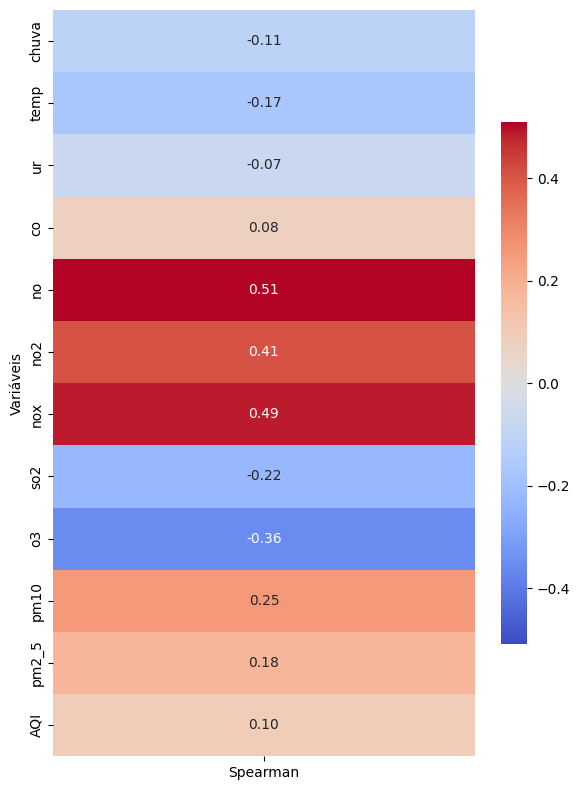

In [6]:
vars_x = ['chuva','temp','ur','co','no','no2','nox','so2','o3','pm10','pm2_5', 'AQI']

data = df_unificado[['num_internacoes'] + vars_x].dropna()

corr_spearman = data.corr(method='spearman').loc['num_internacoes', vars_x]

vlim = float(np.nanmax(np.abs(corr_spearman)))

plt.figure(figsize=(6, 8))

sns.heatmap(
    pd.DataFrame(corr_spearman.values, index=vars_x, columns=['Spearman']),
    cmap='coolwarm', center=0, vmin=-vlim, vmax=vlim,
    annot=True, fmt=".2f", cbar=True, cbar_kws={"shrink": 0.7}
)
# plt.title("Correlação com num_internacoes — Spearman")
plt.xlabel("")
plt.ylabel("Variáveis")

plt.tight_layout()
plt.show()

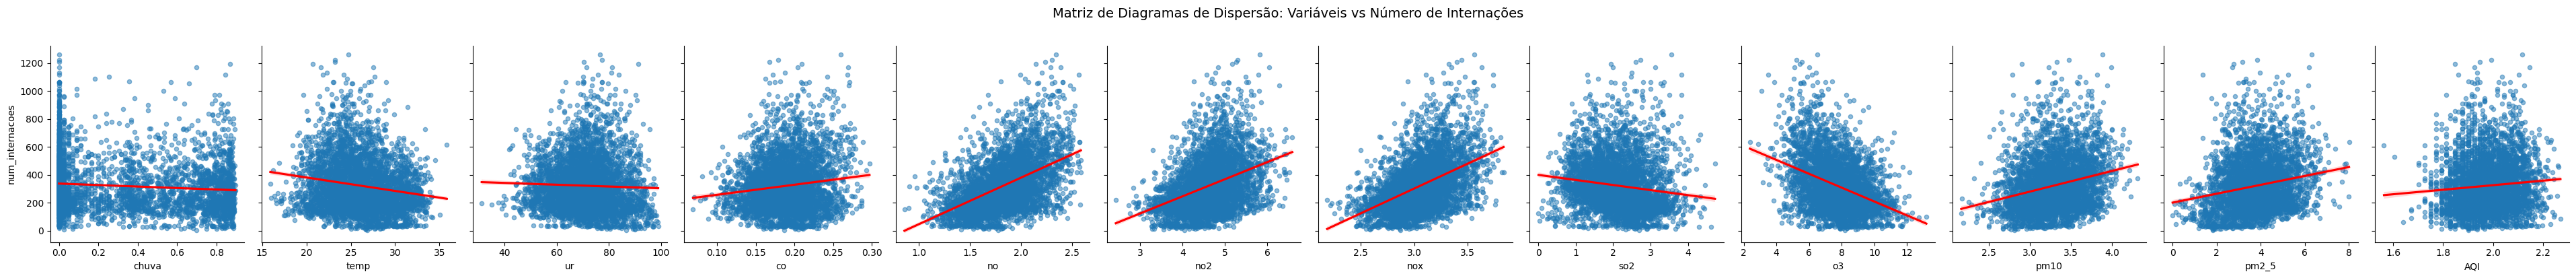

In [7]:
vars_x = ['chuva','temp','ur','co','no','no2','nox','so2','o3','pm10','pm2_5', 'AQI']

# Selecionar apenas as variáveis de interesse
data = df_unificado[['num_internacoes'] + vars_x].dropna()

# Criar a matriz de scatter plots
sns.pairplot(data, 
             y_vars=['num_internacoes'],
             x_vars=vars_x,
             kind='reg',  # Adiciona linha de tendência
             plot_kws={'scatter_kws': {'alpha': 0.5, 's': 20},
                      'line_kws': {'color': 'red'}},
             height=4,
             aspect=0.8)

plt.suptitle('Matriz de Diagramas de Dispersão: Variáveis vs Número de Internações', 
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

**Leituras principais**
- **Maiores correlações positivas:** `NO (r=0,50; ρ=0,51)`, `NOx (r=0,47; ρ=0,49)`, `NO₂ (r=0,38; ρ=0,41)`.  
  - Sinal **consistente** entre Pearson e Spearman
- **Correlação negativa mais evidente:** `O₃ (r=−0,38; ρ=−0,36)`.  
  - Sinal oposto aos óxidos de nitrogênio, compatível com **fotossíntese/fotoquímica** e regimes meteorológicos distintos.
- **Particulados com associação positiva moderada:** `PM10 (r=0,24; ρ=0,25)` e `PM2.5 (r=0,19; ρ=0,18)`.  
  - Efeito presente, porém **mais fraco** que NO/NOx/NO₂.
- **Outras variáveis:** `SO₂ (r=−0,14; ρ=−0,22)`, `CO (r=0,13; ρ=0,08)`, `AQI (r=0,06; ρ=0,10)`, `temp (r=−0,17; ρ=−0,17)`, `chuva (r=−0,09; ρ=−0,11)`, `UR (r=−0,04; ρ=−0,07)`.  
  - Em geral **fracas** (|ρ| < 0,2). `SO₂` fica **mais negativo em Spearman**, sugerindo **não linearidade**/outliers.

**Interpretação operacional**
- **Foco para modelagem/monitoramento:** incluir `NO`, `NOx`, `NO₂` como preditores-chave; 
- **Sinal oposto do O₃:** considerar **interações com temperatura/insolação** e controlar clima/sazonalidade para isolar efeito.
- **Particulados:** manter `PM10`/`PM2.5` no modelo (efeito **moderado**); avaliar **termos não lineares** (splines/LOESS) e **faixas de exposição**.

## 2) Dose–resposta (nível atual, sem defasagem)

#### 2.1) Hexbin (reduz overplotting) – grade de variáveis

C:\Users\jhter\AppData\Local\Temp\ipykernel_10008\100666581.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


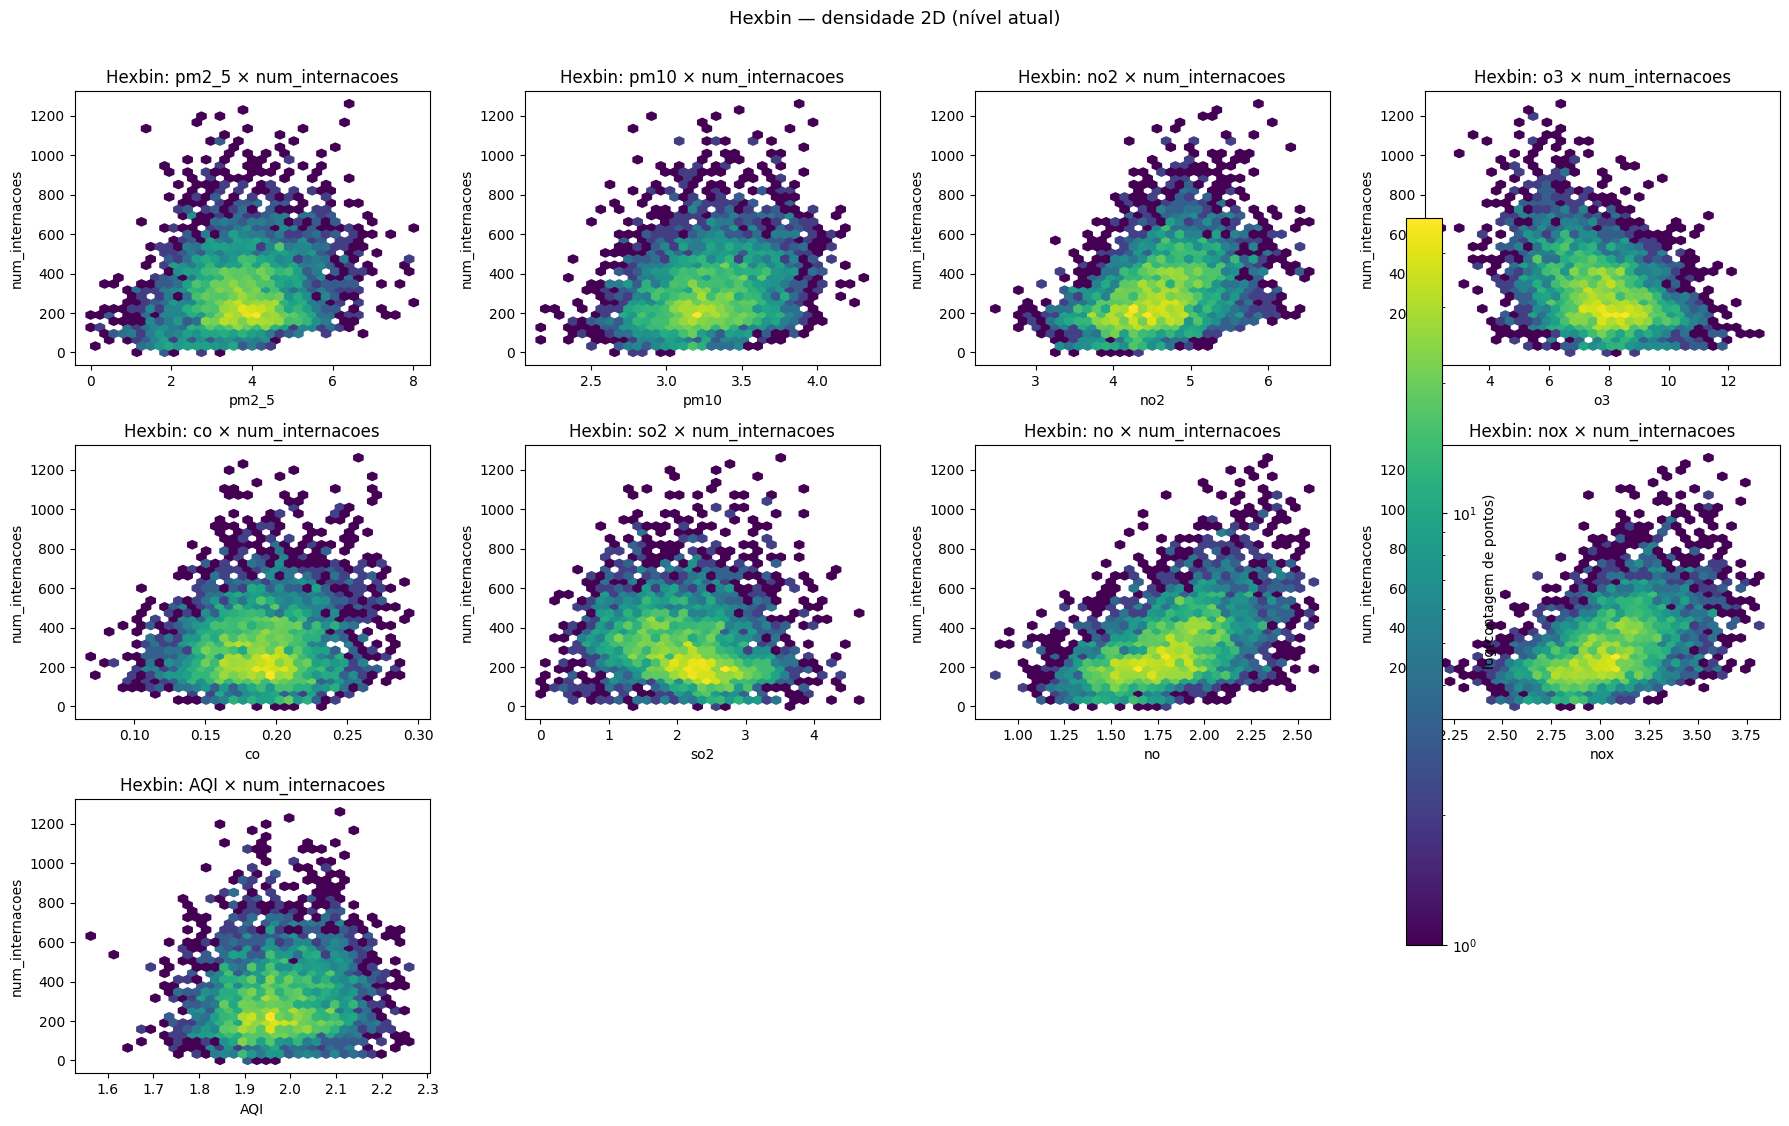

In [8]:
vars_x = ['pm2_5','pm10','no2','o3','co','so2','no','nox','AQI']
data = df_unificado[['num_internacoes'] + vars_x].dropna()

n = len(vars_x)
ncols = 4
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5*ncols, 3.7*nrows), sharey=False)
axes = axes.ravel()

mappable = None
for i, var in enumerate(vars_x):
    ax = axes[i]
    hb = ax.hexbin(data[var].values, data['num_internacoes'].values,
                gridsize=35, bins='log', mincnt=1) 
    ax.set_xlabel(var)
    ax.set_ylabel('num_internacoes')
    ax.set_title(f"Hexbin: {var} × num_internacoes")
    mappable = hb  

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

cbar = fig.colorbar(mappable, ax=axes[:i+1], shrink=0.85)
cbar.set_label('log(contagem de pontos)')

fig.suptitle("Hexbin — densidade 2D (nível atual)", y=1.01, fontsize=13)
fig.tight_layout()
plt.show()

**Leituras principais**
- **Gradiente positivo claro (inclinação ascendente):** `NO`, `NOx` e `NO₂` exibem nuvens diagonais bem definidas, com maior densidade (miolo amarelo) à medida que o poluente cresce. 
- **Gradiente negativo nítido:** `O₃` mostra inclinação **descendente** — maiores valores de ozônio associam-se a **menos** internações.  
  - Sinal **oposto** aos óxidos de nitrogênio, coerente com regimes fotoquímicos distintos.
- **Particulados com associação positiva moderada:** `PM10` e `PM2.5` têm densidade crescente com o eixo x, porém com **nuvem mais difusa** (dispersão alta).  

**Interpretação operacional**
- **Preditores prioritários:** `NO`, `NOx`, `NO₂` (positivos) e `O₃` (negativo).  
  - Modelar com **termos não lineares** (splines/LOESS) e **defasagens**, dado o leque em níveis altos.

## 3) Defasagens (efeitos de LAG)

#### 3.1) CCF — correlação cruzada (lags), uma curva por variável

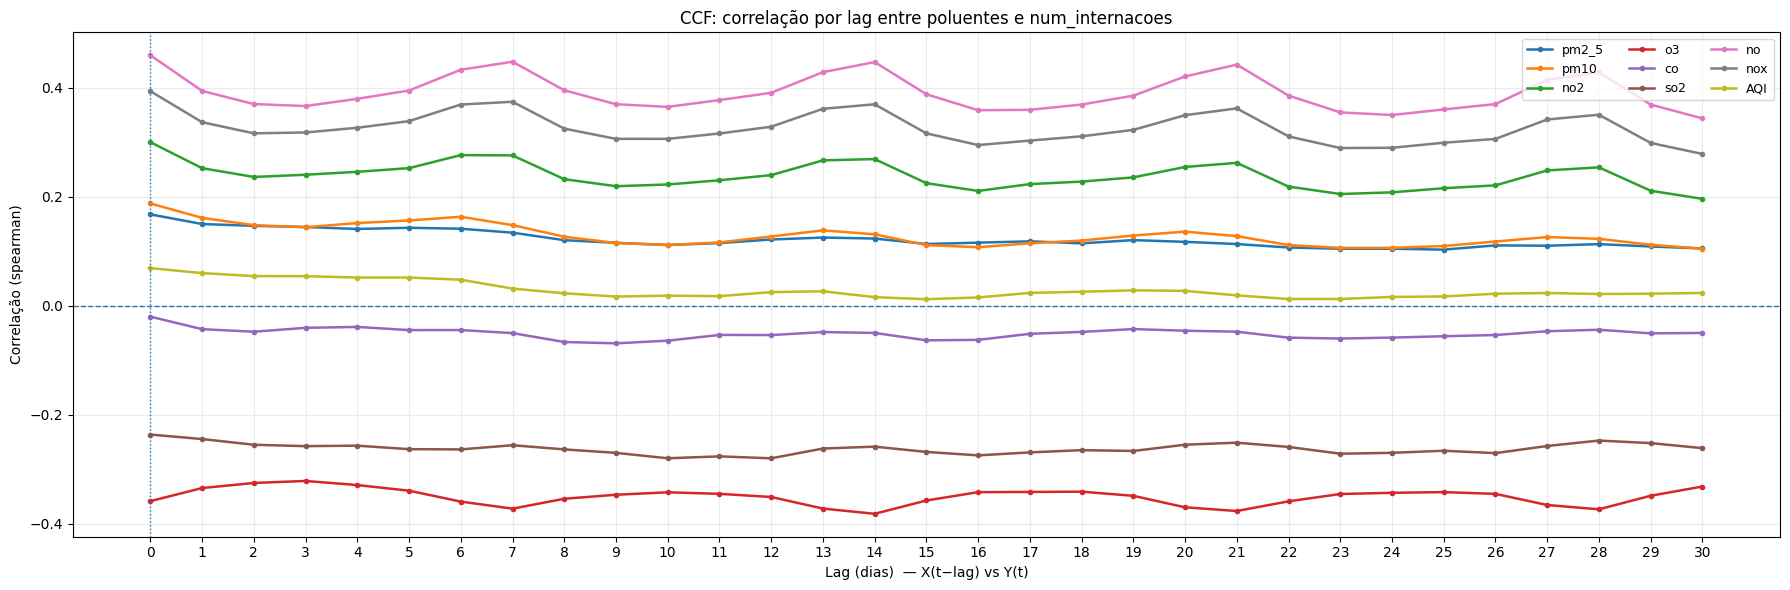

In [9]:
df = df_unificado.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'])
df = df.sort_values('data_dia').set_index('data_dia')
df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

y = df['num_internacoes']

# Variáveis (poluentes + AQI). Adicione/remova conforme desejar.
vars_x = ['pm2_5','pm10','no2','o3','co','so2','no','nox','AQI']

max_lag = 30
method = 'spearman'

lags = np.arange(0, max_lag + 1)
ccf_dict = {}

for v in vars_x:
    r = []
    x = df[v]
    for k in lags:
        tmp = pd.concat({'y': y, 'x': x.shift(k)}, axis=1).dropna()
        r.append(tmp['y'].corr(tmp['x'], method=method))
    ccf_dict[v] = np.array(r)

# --- Plot
plt.figure(figsize=(18, 6))
for v in vars_x:
    plt.plot(lags, ccf_dict[v], marker='o', ms=3, lw=1.8, label=v)

plt.axhline(0, ls='--', lw=1)
plt.axvline(0, ls=':', lw=1)
plt.xticks(lags)
plt.xlabel('Lag (dias)  — X(t−lag) vs Y(t)')
plt.ylabel(f'Correlação ({method})')
plt.title('CCF: correlação por lag entre poluentes e num_internacoes')
plt.legend(ncol=3, frameon=True, fontsize=9)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

#### 3.2) Heatmap lag–variável

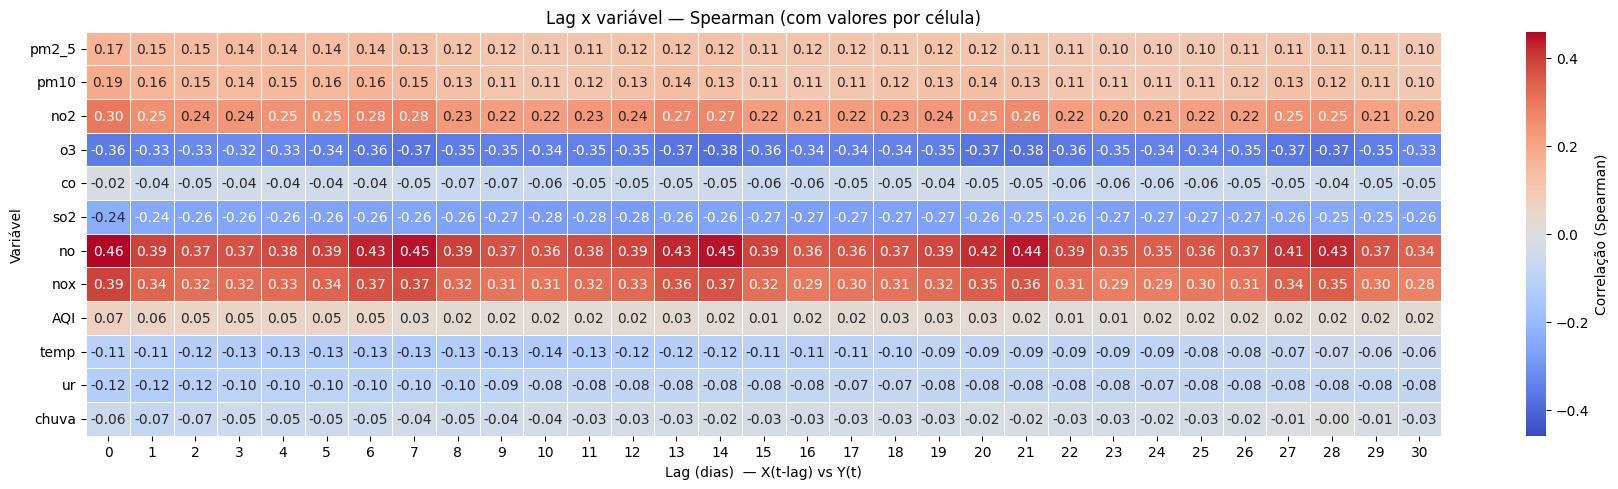

In [10]:
df = df_unificado.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'])
df = df.sort_values('data_dia').set_index('data_dia')
df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

y = df['num_internacoes']

vars_x = ['pm2_5','pm10','no2','o3','co','so2','no','nox','AQI', 'temp','ur','chuva']

max_lag = 30
lags = np.arange(0, max_lag + 1)

M = np.full((len(vars_x), len(lags)), np.nan, dtype=float)
for i, v in enumerate(vars_x):
    x = df[v]
    for j, k in enumerate(lags):
        tmp = pd.concat({'y': y, 'x': x.shift(k)}, axis=1).dropna()
        if len(tmp) > 1:
            M[i, j] = tmp['y'].corr(tmp['x'], method='spearman')

M_df = pd.DataFrame(M, index=vars_x, columns=lags)

vlim = float(np.nanmax(np.abs(M_df.values)))

plt.figure(figsize=(18, 5))
ax = sns.heatmap(
    M_df, cmap='coolwarm', center=0, vmin=-vlim, vmax=vlim,
    annot=True, fmt=".2f", linewidths=0.5,
    cbar_kws={'label': 'Correlação (Spearman)'}
)
ax.set_xlabel('Lag (dias)  — X(t-lag) vs Y(t)')
ax.set_ylabel('Variável')
ax.set_title('Lag x variável — Spearman (com valores por célula)')
plt.tight_layout()
plt.show()


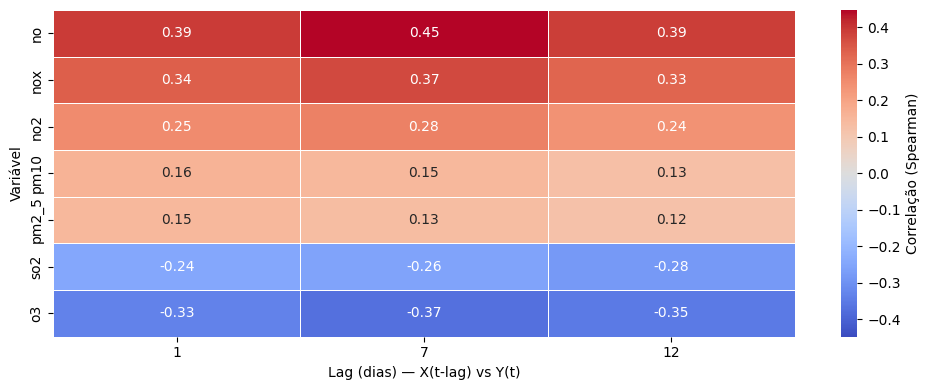

Tabela de correlações (Spearman):
             1         7         12
no     0.393833  0.447393  0.390380
nox    0.336384  0.373886  0.328156
no2    0.252116  0.275551  0.239386
pm10   0.161021  0.147683  0.126805
pm2_5  0.149686  0.133869  0.121321
so2   -0.244688 -0.255983 -0.279984
o3    -0.334553 -0.372353 -0.350933


In [11]:
# Mapeamento de lags para cada variável
lags_map = {
    'no': [1, 7, 12],
    'nox': [1, 7, 12],
    'no2': [1, 7, 12],
    'pm10': [1, 7, 12],
    'pm2_5': [1, 7, 12],
    'so2': [1, 7, 12],
    'o3': [1, 7, 12],
}

# Supondo que df_unificado já está definido
df = df_unificado.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'])
df = df.sort_values('data_dia').set_index('data_dia')
df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

y = df['num_internacoes']

# Usar apenas as variáveis do dicionário lags_map
vars_x = list(lags_map.keys())

# Coletar todos os lags únicos do mapeamento
all_lags = []
for lags_list in lags_map.values():
    all_lags.extend(lags_list)
all_lags = sorted(set(all_lags))

# Criar matriz para armazenar as correlações
M = np.full((len(vars_x), len(all_lags)), np.nan, dtype=float)

# Calcular correlações apenas para os lags especificados
for i, var in enumerate(vars_x):
    x = df[var]
    lags_variavel = lags_map[var]
    
    for j, lag in enumerate(all_lags):
        if lag in lags_variavel:
            tmp = pd.concat({'y': y, 'x': x.shift(lag)}, axis=1).dropna()
            if len(tmp) > 1:
                M[i, j] = tmp['y'].corr(tmp['x'], method='spearman')
        else:
            # Deixar como NaN para lags não aplicáveis
            M[i, j] = np.nan

# Criar DataFrame com os resultados
M_df = pd.DataFrame(M, index=vars_x, columns=all_lags)

# Encontrar valor máximo absoluto para definir os limites do heatmap
vlim = float(np.nanmax(np.abs(M_df.values)))

# Configurar a figura
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    M_df, 
    cmap='coolwarm', 
    center=0, 
    vmin=-vlim if vlim > 0 else -1, 
    vmax=vlim if vlim > 0 else 1,
    annot=True, 
    fmt=".2f", 
    linewidths=0.5,
    cbar_kws={'label': 'Correlação (Spearman)'},
    mask=np.isnan(M_df)  # Mascarar valores NaN
)
ax.set_xlabel('Lag (dias) — X(t-lag) vs Y(t)')
ax.set_ylabel('Variável')
plt.tight_layout()
plt.show()

# Opcional: Mostrar também em formato de tabela
print("Tabela de correlações (Spearman):")
print(M_df)

**Leituras principais**
- **Associações positivas mais fortes e persistentes:**  
  - `NO` atinge **ρ≈0,46 em lag 0** e permanece **elevado (≈0,39–0,44)** em praticamente **todos** os lags até 30 — picos visíveis em ~**0/14/21**.  
  - `NOx` inicia em **ρ≈0,36 (lag 0)** e oscila num **platô 0,31–0,37**, com ressaltos em ~**14/21/29**.  
  - `NO₂` é **moderado** (**ρ≈0,30** em lag 0), decaindo suavemente para **≈0,20–0,28**.
- **Associações negativas robustas:**  
  - `O₃` permanece **fortemente negativo** em todos os lags (**ρ≈−0,33 a −0,38**), com mínimos em torno de **14** e **21** dias.  
  - `SO₂` é **moderado e estável** (**ρ≈−0,24 a −0,27**).
- **Particulados com efeito curto e modesto:**  
  - `PM10` (**ρ≈0,19** em lag 0) e `PM2.5` (**ρ≈0,17**) caem para **≈0,10–0,12** conforme o lag aumenta ⇒ **efeito mais imediato** que acumulado.  
- **Variáveis meteorológicas fracas e quase planas no lag:**  
  - `temp` (≈**−0,11**), `UR` (≈**−0,10/−0,12**) e `chuva` (**−0,06 → −0,02** perto de ~21) mantêm **|ρ| baixo**.  
- **AQI** é **fraco e estável** (**ρ≈0,06–0,08**) — o índice agregado **dilui** sinais opostos (NOx positivo vs O₃ negativo).

**Interpretação operacional**
- **Janela temporal dominante:** para **NO/NOx/NO₂**, o efeito é **quase imediato e persistente** (lags **0–3** já são altos e se mantêm).  
  - Em modelagem, considerar **DLNM** ou **médias móveis** curtas (**3–7d**) possivelmente com **shift 0–3d**.  
- **O₃** apresenta **efeito negativo sustentado** (até ~**21d**): incluir **lags distribuídos** (0–14/21) e testar **não linearidade**.  
- **Particulados (PMs)**: como o sinal **decai com o lag**, priorize `X_t` e **acúmulos curtos** (3–7d); ganhos marginais em janelas longas são limitados.  
- **Sazonalidade semanal:** ressalto em lags **≈7/14/21** para NO/NOx pode refletir **ciclo semanal**; controlar por **dia da semana** evita atribuir esse padrão ao poluente.  

#### 3.3) Correlação com janelas móveis (efeito acumulado)

In [12]:
tgt = "num_internacoes"
features = ['pm2_5','pm10','no2','o3','co','so2','no','nox']
windows  = [3, 7, 14, 21, 30, 60, 90, 120, 150]
shifts   = [1, 7, 14, 21]
top_n    = 20

df = df_unificado.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'])
df = df.sort_values('data_dia').set_index('data_dia')
df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='D'))

y = df[tgt].astype(float)

results = []

def add_result(feat, w, s, series_x):
    tmp = pd.concat({'y': y, 'x': series_x}, axis=1).dropna()
    if len(tmp) >= max(60, (w if (w is not None) else 1)):
        rho = tmp['y'].corr(tmp['x'], method='spearman')
        if pd.notna(rho):
            results.append({
                'feature': feat,
                'window': (w if w is not None else 1),
                'shift': (s if s is not None else 0),
                'rho': rho,
                'abs_rho': abs(rho),
                'is_point': (w is None and s is None) 
            })

for f in features:
    x = df[f].astype(float)

    add_result(f, w=None, s=None, series_x=x)

    for s in shifts:
        x_shift = x.shift(s)
        for w in windows:
            x_ma = x_shift.rolling(window=w, min_periods=w).mean()
            add_result(f, w=w, s=s, series_x=x_ma)

res_df = pd.DataFrame(results)
if res_df.empty:
    raise RuntimeError("Sem dados suficientes para calcular correlações. Verifique janelas/intervalo de datas.")

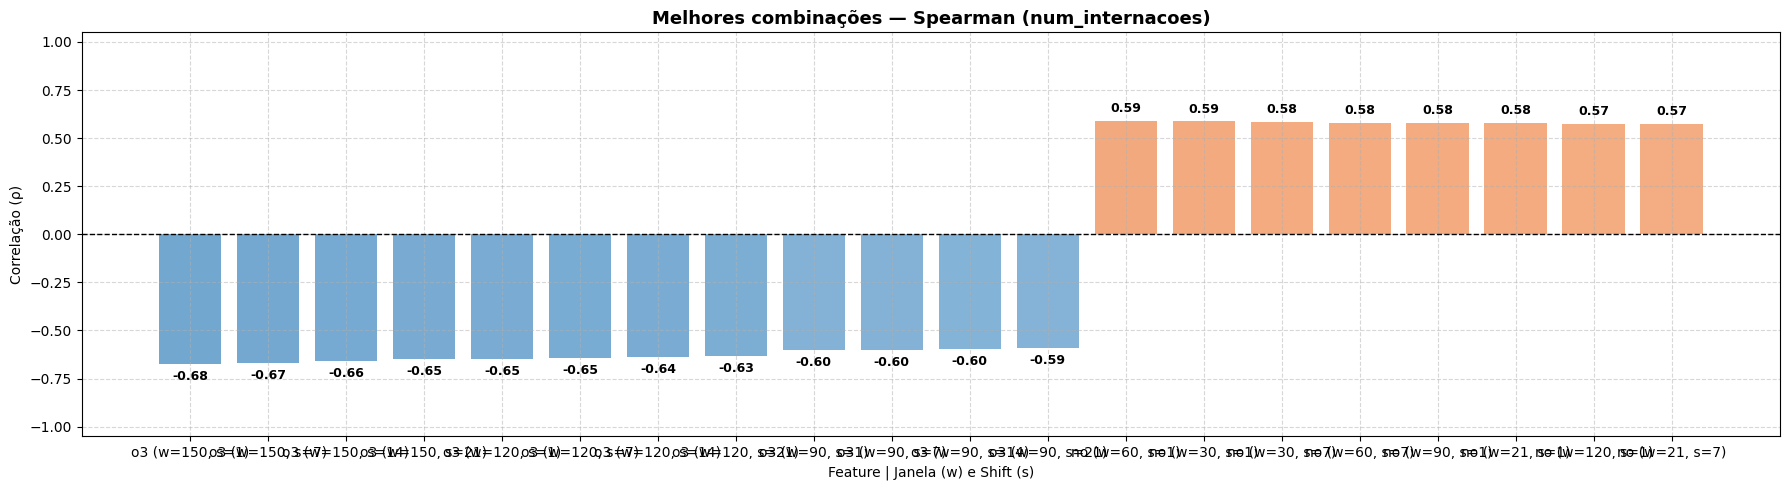


TOP combinações (por |ρ|):
feature  window  shift       rho  abs_rho
     o3     150      1 -0.676858 0.676858
     o3     150      7 -0.671308 0.671308
     o3     150     14 -0.660833 0.660833
     o3     150     21 -0.648506 0.648506
     o3     120      1 -0.647160 0.647160
     o3     120      7 -0.645654 0.645654
     o3     120     14 -0.640190 0.640190
     o3     120     21 -0.632198 0.632198
     o3      90      1 -0.601839 0.601839
     o3      90      7 -0.600692 0.600692
     o3      90     14 -0.596574 0.596574
     o3      90     21 -0.590656 0.590656
     no      60      1  0.590508 0.590508
     no      30      1  0.586676 0.586676
     no      30      7  0.582397 0.582397
     no      60      7  0.580990 0.580990
     no      90      1  0.580973 0.580973
     no      21      1  0.580492 0.580492
     no     120      1  0.574685 0.574685
     no      21      7  0.573773 0.573773


In [13]:
# Gráfico 1: Top N combinações
top = res_df.sort_values('abs_rho', ascending=False).head(top_n).copy()

labels = [
    f"{row.feature} (w={int(row.window)}, s={int(row.shift)})" if not row.is_point
    else f"{row.feature} (X_t)"
    for row in top.itertuples(index=False)
]
vals = top['rho'].values

POS_LO = (253/255, 208/255, 162/255) 
POS_HI = (230/255,  85/255,  13/255)  
NEG_LO = (158/255, 202/255, 225/255)  
NEG_HI = ( 33/255, 113/255, 181/255)  

def blend(c_lo, c_hi, t):
    import numpy as np
    return tuple((1 - t) * np.array(c_lo) + t * np.array(c_hi))

bar_colors = []
for r in vals:
    t = max(0.0, min(1.0, abs(float(r))))          
    rgb = blend(POS_LO, POS_HI, t) if r >= 0 else blend(NEG_LO, NEG_HI, t)
    alpha = 0.3 + 0.7*t                             
    bar_colors.append((*rgb, alpha))

plt.figure(figsize=(max(14, 0.9*len(top)), 5))
bars = plt.bar(labels, vals, color=bar_colors, edgecolor="none")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.ylim(-1.05, 1.05)
plt.title(f"Melhores combinações — Spearman ({tgt})", fontsize=13, fontweight="bold")
plt.xlabel("Feature | Janela (w) e Shift (s)")
plt.ylabel("Correlação (ρ)")
plt.grid(True, linestyle="--", alpha=0.5)

for rect, val in zip(bars, vals):
    x = rect.get_x() + rect.get_width()/2
    y = val + (0.03 if val >= 0 else -0.03)
    va = "bottom" if val >= 0 else "top"
    plt.text(x, y, f"{val:.2f}", ha="center", va=va, fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

print("\nTOP combinações (por |ρ|):")
print(top[['feature','window','shift','rho','abs_rho']].to_string(index=False))

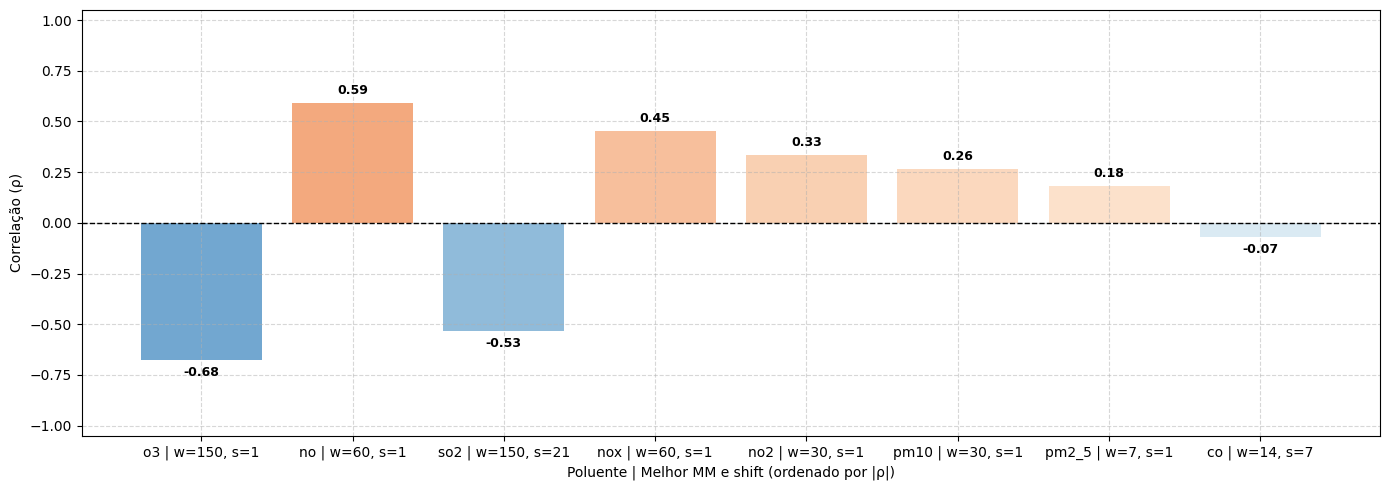


Melhor janela+lag por poluente (ordenado por |ρ|):
feature  window  shift       rho  abs_rho
     o3     150      1 -0.676858 0.676858
     no      60      1  0.590508 0.590508
    so2     150     21 -0.534567 0.534567
    nox      60      1  0.453012 0.453012
    no2      30      1  0.333275 0.333275
   pm10      30      1  0.264183 0.264183
  pm2_5       7      1  0.181937 0.181937
     co      14      7 -0.070009 0.070009


In [30]:
# Gráfico 2 (estilizado): Melhor janela+lag por poluente, ordenado por |ρ|
best_idx = res_df.groupby('feature')['abs_rho'].idxmax()
best = res_df.loc[best_idx].copy()
best_sorted = best.sort_values('abs_rho', ascending=False).reset_index(drop=True)

def blend(c_lo, c_hi, t):
    """Interpola entre duas cores RGB (0..1). t em [0,1]."""
    import numpy as np
    return tuple((1 - t) * np.array(c_lo) + t * np.array(c_hi))

ALPHA_INVERT = False  

labels2, vals2, bar_colors = [], [], []
for row in best_sorted.itertuples(index=False):
    labels2.append(f"{row.feature} | " + ("X_t" if row.is_point else f"w={int(row.window)}, s={int(row.shift)}"))
    r = float(row.rho)
    vals2.append(r)
    t = max(0.0, min(1.0, abs(r)))              # força
    rgb = blend(POS_LO, POS_HI, t) if r >= 0 else blend(NEG_LO, NEG_HI, t)
    alpha = (0.3 + 0.7*t) if not ALPHA_INVERT else (1.0 - 0.7*t)
    bar_colors.append((*rgb, alpha))

plt.figure(figsize=(max(14, 0.9*len(best_sorted)), 5))
bars2 = plt.bar(labels2, vals2, color=bar_colors, edgecolor="none")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.ylim(-1.05, 1.05)
# plt.title(f"Melhor janela+lag por poluente — Spearman ({tgt})", fontsize=13, fontweight="bold")
plt.xlabel("Poluente | Melhor MM e shift (ordenado por |ρ|)")
plt.ylabel("Correlação (ρ)")
plt.grid(True, linestyle="--", alpha=0.5)

for rect, val in zip(bars2, vals2):
    x = rect.get_x() + rect.get_width()/2
    y = val + (0.03 if val >= 0 else -0.03)
    va = "bottom" if val >= 0 else "top"
    plt.text(x, y, f"{val:.2f}", ha="center", va=va, fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

print("\nMelhor janela+lag por poluente (ordenado por |ρ|):")
print(best_sorted[['feature','window','shift','rho','abs_rho']].to_string(index=False))

**Leituras principais**
- **Efeito acumulado forte (negativo) para O₃:** melhor combinação **`w=150, s=1`** com **ρ≈−0,68**.  
  - Ganho substancial vs valor pontual (lag 0 ≈ **−0,36**): longas janelas capturam **tendência/sazonalidade** associada a menores internações quando O₃ está alto.
- **Efeito acumulado forte (positivo) para gases de tráfego:**  
  - **NO**: **`w=60, s=1` → ρ≈0,59** (↑ vs lag 0 ≈ **0,46**).  
  - **NOx**: **`w=60, s=1` → ρ≈0,45** (↑ vs lag 0 ≈ **0,36**).  
  - **NO₂**: **`w=30, s=1` → ρ≈0,33** (↑ vs lag 0 ≈ **0,30**).  
  - Padrão sugere que **média recente (1–2 meses)** explica melhor o alvo que o valor diário.
- **Particulados com ganho modesto:**  
  - **PM10**: **`w=30, s=1` → ρ≈0,26** (levemente ↑ vs lag 0 ≈ **0,19**).  
  - **PM2.5**: **`w=7, s=1` → ρ≈0,18** (≈ estável vs lag 0 ≈ **0,17**).  
  - Indica **efeito mais imediato** (janelas muito longas não aumentam o sinal).
- **SO₂ com acúmulo relevante e tardio:** **`w=150, s=21` → ρ≈−0,53** (bem mais negativo que lag 0 ≈ **−0,24**), sugerindo **efeito acumulado/longo prazo**.
- **AQI** melhora pouco com acúmulo: **`w=150, s=21` → ρ≈0,22**, coerente com o fato do índice **mesclar sinais opostos**.

**Interpretação operacional**
- **Quando usar acúmulo:**  
  - Para **NO/NOx** usar médias móveis **curtas–médias** (≈ **30–60d**) com **s=1**; para **O₃** (negativo) e **SO₂** (negativo) as janelas **longas (≈150d)** capturam melhor o comportamento.  
  - Para **PMs**, priorize **Xₜ** e **janelas curtas (3–7/30d)** — ganhos em janelas longas são pequenos.
- **Cautela com sazonalidade semanal/anual:**  
  - Ganhos em `w=60–150` podem refletir **componentes sazonais** compartilhados com `num_internacoes`.  
  - Antes de concluir causalidade, recompute ρ com **resíduos parciais** (controlando **dia da semana**, **tendência/ano/mês**, **temp**, **UR**, **chuva**).
- **Escolhas para modelagem (features candidatas):**  
  - `\bar{NO}_{t-1}^{(60)}`, `\bar{NOx}_{t-1}^{(60)}`, `\bar{NO2}_{t-1}^{(30)}` (efeitos positivos).  
  - `\bar{O3}_{t-1}^{(150)}` e `\bar{SO2}_{t-21}^{(150)}` (efeitos negativos).  
  - `\bar{PM10}_{t-1}^{(30)}` e `\bar{PM2.5}_{t-1}^{(7)}` (ganhos modestos, foco curto prazo).  
  - Evite multicolinearidade escolhendo **um representante** do grupo NO/NOx/NO₂ ou usando **PCA/elastic net**.
- **Validações sugeridas:**  
  1) Cross-validation comparando modelos com **Xₜ** vs **acúmulos**;  
  2) Repetir sem **dias extremos** (≥ p95) e medir estabilidade dos ρ;  
  3) Estimar **DLNM/GAM** para capturar simultaneamente **defasagem e não linearidade**.

**Resumo**
- O **efeito acumulado** melhora substancialmente a explicação para **O₃** (negativo) e **gases de tráfego** (**NO/NOx**, positivo), enquanto traz **ganhos modestos** para **PMs**.  
- Em termos operacionais, combine **acúmulos de 30–60d** (tráfego) com **janelas longas**


## 4. Gerando features a partir dos resultados

#### 4.1 Features do mapa de calor

In [14]:
df_base = df_unificado.copy()
df_base['data_dia'] = pd.to_datetime(df_base['data_dia'])
df_base = df_base.sort_values('data_dia').reset_index(drop=True)

target_col = 'num_internacoes'

candidates = ['no','nox','no2','o3','pm10','pm2_5','co','so2','AQI','temp','ur','chuva']

# Seleção automática por Spearman (lag 0)
tmp = df_base[[target_col] + candidates].dropna()
spearman = tmp.corr(method='spearman').loc[target_col, candidates].sort_values(ascending=False)

THRESH = 0.30  
selected = spearman[abs(spearman) >= THRESH].index.tolist()

# Garante presença de variáveis essenciais (negativas também carregam sinal informativo)
must_have = ['o3']  
selected = sorted(set(selected) | (set(must_have) & set(candidates)))

print("Spearman (lag 0) por variável:")
print(spearman.to_string())
print("\nSelecionadas (|ρ| ≥ {:.2f}, com garantia para O3): {}".format(THRESH, selected))

# Monta df_final com alvo + features do dia t
rename_map = {c: f"{c}_t" for c in selected}

df_final = pd.DataFrame({
    'data_dia': df_base['data_dia'],                    
    target_col: df_base[target_col].astype(float)
})
for c in selected:
    df_final[rename_map[c]] = df_base[c].astype(float)

# Interações inspiradas pelo mapa (sinal oposto NOx ↔ O3)
if {'nox','o3'}.issubset(set(selected)):
    df_final['nox_x_o3_t'] = df_base['nox'].astype(float) * df_base['o3'].astype(float)
    
# Limpeza final
# df_final = df_final.dropna().reset_index(drop=True)

display(df_final.head())
print(df_final.shape)

Spearman (lag 0) por variável:
no       0.509938
nox      0.487183
no2      0.408713
pm10     0.251081
pm2_5    0.175452
AQI      0.097721
co       0.077615
ur      -0.072300
chuva   -0.113358
temp    -0.174157
so2     -0.223483
o3      -0.356910

Selecionadas (|ρ| ≥ 0.30, com garantia para O3): ['no', 'no2', 'nox', 'o3']


,data_dia,num_internacoes,no_t,no2_t,nox_t,o3_t,nox_x_o3_t
0,2012-01-01,507.0,1.256189,4.184802,2.770516,6.469835,17.924784
1,2012-01-02,728.0,1.884591,4.419030,3.019050,6.013862,18.156151
2,2012-01-03,429.0,2.021231,4.512331,3.108324,5.246714,16.308486
3,2012-01-04,416.0,2.175012,5.096621,3.324094,6.754888,22.453881
4,2012-01-05,403.0,2.007440,4.843477,3.181217,7.889395,25.097879


(4748, 7)


#### 4.2 Features a partir do gráfico de lags

In [15]:
_df = df_unificado.copy()
_df['data_dia'] = pd.to_datetime(_df['data_dia'])
_df = _df.sort_values('data_dia').reset_index(drop=True)

# Especificação de features guiada pelos lags
lags_map = {
    'no'   : [1, 7],
    'o3'   : [1, 7],
    'pm10' : [1],
    'pm2_5': [1],
    'so2'  : [12],
}
MA_SHIFT = 1 

# Helpers
def build_lag_features(df_src, lags_dict):
    out = pd.DataFrame({'data_dia': df_src['data_dia']})
    for var, lags in lags_dict.items():
        s = df_src[var].astype(float)
        for k in lags:
            out[f'{var}_lag{k}'] = s.shift(k)
    return out

def build_ma_features(df_src, ma_dict, shift=1):
    out = pd.DataFrame({'data_dia': df_src['data_dia']})
    for var, wins in ma_dict.items():
        s = df_src[var].astype(float).shift(shift)  # exclui o dia t
        for w in wins:
            out[f'{var}_ma{w}_s{shift}'] = s.rolling(window=w, min_periods=w).mean()
    return out

# Geração
lag_df = build_lag_features(_df, lags_map)

df_final = df_final.merge(lag_df, on='data_dia', how='left')

# Limpeza final (remove linhas iniciais com NaN gerados por lags/MAs)
# df_final = df_final.dropna().reset_index(drop=True)

print("Novas colunas adicionadas (amostra):")
new_cols = [c for c in df_final.columns if any(tag in c for tag in ['_lag'])]
display(df_final.head())
print(df_final.shape)

Novas colunas adicionadas (amostra):


,data_dia,num_internacoes,no_t,no2_t,nox_t,o3_t,nox_x_o3_t,no_lag1,no_lag7,o3_lag1,o3_lag7,pm10_lag1,pm2_5_lag1,so2_lag12
0,2012-01-01,507.0,1.256189,4.184802,2.770516,6.469835,17.924784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,728.0,1.884591,4.419030,3.019050,6.013862,18.156151,1.256189,NaN,6.469835,NaN,3.015162,3.838250,NaN
2,2012-01-03,429.0,2.021231,4.512331,3.108324,5.246714,16.308486,1.884591,NaN,6.013862,NaN,2.557084,2.239978,NaN
3,2012-01-04,416.0,2.175012,5.096621,3.324094,6.754888,22.453881,2.021231,NaN,5.246714,NaN,3.020044,2.008542,NaN
4,2012-01-05,403.0,2.007440,4.843477,3.181217,7.889395,25.097879,2.175012,NaN,6.754888,NaN,3.353868,3.968771,NaN


(4748, 14)


#### 4.3 Features de efeito acumulado (Médias Móveis)

In [16]:
_src = df_unificado.copy()
_src['data_dia'] = pd.to_datetime(_src['data_dia'])
_src = _src.sort_values('data_dia').reset_index(drop=True)

spec = {
    'no'   : [(60, 1)],   # ρ≈0,59
    'nox'  : [(60, 1)],   # ρ≈0,45
    'no2'  : [(30, 1)],   # ρ≈0,33
    'o3'   : [(150, 1)],  # ρ≈-0,68 (forte e negativo)
    'so2'  : [(150, 21)], # ρ≈-0,53 (acúmulo tardio)
    'pm10' : [(30, 1)],   # ganho modesto
    'pm2_5': [(7, 1)],    # efeito mais imediato
}

def build_rolling_ma(df_src, specs):
    out = pd.DataFrame({'data_dia': df_src['data_dia']})
    for var, combos in specs.items():
        if var not in df_src.columns:
            raise KeyError(f"Variável '{var}' não encontrada em df_unificado.")
        base = df_src[var].astype(float)
        for (w, s) in combos:
            series = base.shift(s).rolling(window=w, min_periods=w).mean()
            out[f'{var}_ma{w}_s{s}'] = series
    return out

ma_accum_df = build_rolling_ma(_src, spec)

df_final = df_final.merge(ma_accum_df, on='data_dia', how='left')

# df_final = df_final.dropna().reset_index(drop=True)

display(df_final.head())
print(df_final.shape)

,data_dia,num_internacoes,no_t,no2_t,nox_t,o3_t,nox_x_o3_t,no_lag1,no_lag7,o3_lag1,...,pm10_lag1,pm2_5_lag1,so2_lag12,no_ma60_s1,nox_ma60_s1,no2_ma30_s1,o3_ma150_s1,so2_ma150_s21,pm10_ma30_s1,pm2_5_ma7_s1
0,2012-01-01,507.0,1.256189,4.184802,2.770516,6.469835,17.924784,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,728.0,1.884591,4.419030,3.019050,6.013862,18.156151,1.256189,NaN,6.469835,...,3.015162,3.838250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,429.0,2.021231,4.512331,3.108324,5.246714,16.308486,1.884591,NaN,6.013862,...,2.557084,2.239978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-04,416.0,2.175012,5.096621,3.324094,6.754888,22.453881,2.021231,NaN,5.246714,...,3.020044,2.008542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-05,403.0,2.007440,4.843477,3.181217,7.889395,25.097879,2.175012,NaN,6.754888,...,3.353868,3.968771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(4748, 21)


In [17]:
print("\nValores ausentes por coluna (top 20):")
na_counts = df_final.isna().sum().sort_values(ascending=False)
na_perc   = (df_final.isna().mean()*100).round(2).sort_values(ascending=False)
display(pd.DataFrame({"NA_count": na_counts, "NA_%": na_perc}).head(20))


Valores ausentes por coluna (top 20):


,NA_count,NA_%
so2_ma150_s21,1103,23.23
pm2_5_ma7_s1,691,14.55
pm2_5_lag1,479,10.09
o3_ma150_s1,471,9.92
so2_lag12,273,5.75
nox_ma60_s1,261,5.50
no_ma60_s1,261,5.50
no2_ma30_s1,141,2.97
pm10_ma30_s1,111,2.34
no_lag7,31,0.65


In [18]:
df_final.rename(columns={'num_internacoes': 'target'}, inplace=True)

project_root = Path().resolve().parents[0]  
output_dir = project_root / "data" / "Final_Datasets"
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / "INTERNACOES_DOENCA_RESP_RJ_QUALIAR_FEATURES.csv"
df_final.to_csv(output_csv_path, index=False, encoding="utf-8")

print(f"Arquivo salvo em: {output_csv_path}")

Arquivo salvo em: C:\Users\jhter\OneDrive - cefet-rj.br\25_2-QualiAr\data\Final_Datasets\INTERNACOES_DOENCA_RESP_RJ_QUALIAR_FEATURES.csv


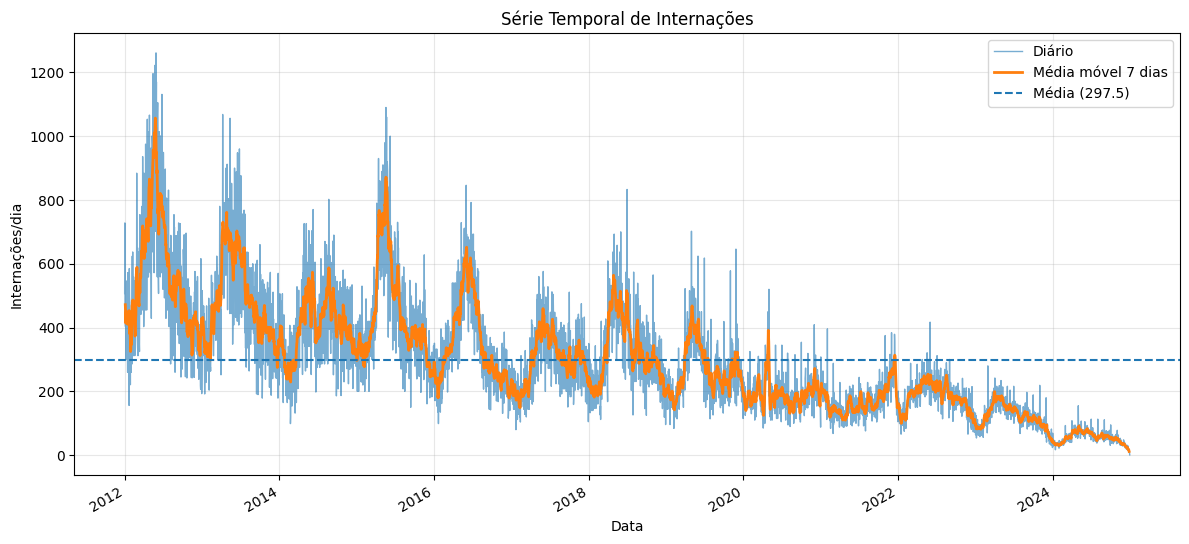

In [17]:
df_final.rename(columns={'target': 'y'}, inplace=True)

ts = df_final.set_index(pd.to_datetime(df_final['data_dia']))['y']

plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, label='Diário', alpha=0.6, linewidth=1)
plt.plot(ts.index, ts.rolling(7, center=True).mean(), label='Média móvel 7 dias', linewidth=2)
mean_val = ts.mean()
plt.axhline(mean_val, linestyle='--', linewidth=1.5, label=f'Média ({mean_val:.1f})')
plt.title('Série Temporal de Internações')
plt.xlabel('Data'); plt.ylabel('Internações/dia')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.gcf().autofmt_xdate()